In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images
x_train = x_train.reshape(60000, -1).astype("float32") / 255.0
x_test  = x_test.reshape(10000, -1).astype("float32") / 255.0


#### Using a PCA to reduce input dimensionality

In [2]:
pca = PCA(n_components=100)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

#### Creating an MLP

In [3]:
# Basic MLP
model = models.Sequential([
    layers.Input(shape=(100,)),
    layers.Dense(75, activation="relu"),
    layers.Dense(40, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 75)                  │           7,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           3,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             410 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,025 (43.07 KB)

 Trainable params: 11,025 (43.07 KB)

 Non-trainable params: 0 (0.00 B)

#### Training an MLP

In [53]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8366 - loss: 0.5732 - val_accuracy: 0.9465 - val_loss: 0.1905
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9435 - loss: 0.1925 - val_accuracy: 0.9613 - val_loss: 0.1333
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9595 - loss: 0.1375 - val_accuracy: 0.9685 - val_loss: 0.1123
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9690 - loss: 0.1060 - val_accuracy: 0.9733 - val_loss: 0.0950
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9753 - loss: 0.0861 - val_accuracy: 0.9752 - val_loss: 0.0881
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.9714 - loss: 0.0944
Test accuracy: 0.9714000225067139


In [54]:
W1 = model.layers[0].weights[0]
W2 = model.layers[1].weights[0]
W3 = model.layers[2].weights[0]

#### Sparse mask function to prune weights from the model (Update epsilon to change sparsity)

In [74]:
def create_sparse_mask(shape, epsilon=8):  
    # SET paper uses epsilon = 11
    nin = shape[0]
    nout = shape[1]
    prob = (epsilon * (nin + nout)) / (nin * nout)
    print(prob)
    return np.random.rand(*shape) < prob

In [1]:
mask1 = create_sparse_mask(W1.shape)
mask2 = create_sparse_mask(W2.shape)
mask3 = create_sparse_mask(W3.shape)

print(mask3)

NameError: name 'W3' is not defined

In [76]:
W1.assign(W1 * mask1)
W2.assign(W2 * mask2)
W3.assign(W3 * mask3)

<tf.Tensor: shape=(40, 10), dtype=float32, numpy=
array([[ 0.01171904, -0.10674472,  0.7777379 ,  0.0058229 ,  0.5404697 ,
        -1.1337512 ,  0.74803746, -0.6382624 ,  0.13614392,  0.10385937],
       [-1.1421899 , -0.69793963, -0.675243  ,  1.4683872 , -0.7065541 ,
         1.1830938 , -0.13376828, -1.0244515 , -0.31677413, -0.1483879 ],
       [-0.78260463,  0.12323244, -1.4802186 , -0.04218892,  0.01259278,
         0.49677983, -0.05831459, -0.7502252 , -0.0130497 ,  0.6403345 ],
       [ 0.08952286, -0.0541672 ,  0.9038    ,  0.11788573,  0.63584524,
         0.26569116,  0.03775496, -1.5151683 , -1.3230062 , -0.9414696 ],
       [ 0.5185066 ,  1.0427818 ,  0.04571229, -0.07142343, -1.2760974 ,
         0.51820165,  0.06429764,  0.4114659 , -2.0898695 ,  0.03864435],
       [-0.6552875 , -2.0849893 ,  0.04331547,  1.557231  , -0.3855296 ,
        -2.0849435 ,  0.06449459, -0.7650133 ,  0.06677049,  0.7158141 ],
       [-1.1477269 , -0.29894024,  0.7490263 , -0.11028282,  0.13853

#### Training the sparse model (Realized that the optimizer would still update the 0 weights so I had to make a custom training loop, see further down)

In [77]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8698 - loss: 0.4739 - val_accuracy: 0.9580 - val_loss: 0.1523
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9548 - loss: 0.1535 - val_accuracy: 0.9670 - val_loss: 0.1187
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9672 - loss: 0.1124 - val_accuracy: 0.9727 - val_loss: 0.0983
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9736 - loss: 0.0898 - val_accuracy: 0.9743 - val_loss: 0.0918
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9779 - loss: 0.0748 - val_accuracy: 0.9780 - val_loss: 0.0859
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9720 - loss: 0.0957
Test accuracy: 0.972000002861023


#### Found out that the zero count was way too high (AKA the zero weights (non connections) get updated during regular training)

In [78]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 7500
Non-zero connections in W2: 3000
Non-zero connections in W3: 400


#### Created a custom training loop

In [79]:
batch_size = 128
N = x_train.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(N).batch(batch_size)

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()


In [80]:
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        preds = model(x_batch)
        loss = loss_fn(y_batch, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Apply masks
    W1.assign(W1 * mask1)
    W2.assign(W2 * mask2)
    W3.assign(W3 * mask3)

    # accuracy
    pred_classes = tf.argmax(preds, axis=1)
    y_batch = tf.cast(y_batch, tf.int64)
    acc = tf.reduce_mean(tf.cast(pred_classes == y_batch, tf.float32))

    return float(loss), acc

In [81]:
for epoch in range(10):
    bar = tqdm(dataset)
    for x_batch, y_batch in bar:
        t0 = time.time()
        loss_value, acc_value = train_step(x_batch, y_batch)
        dt = time.time() - t0
        bar.set_postfix({
            "dt": f"{dt:.4f}s",
            "loss": f"{loss_value:.4f}",
            "acc": f"{acc_value:.4f}"
        })
    print(f"Epoch {epoch+1} done")

100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 260.33it/s, dt=0.1967s, loss=0.3376, acc=0.8958]


Epoch 1 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 447.32it/s, dt=0.0010s, loss=0.1524, acc=0.9688]


Epoch 2 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 445.40it/s, dt=0.0010s, loss=0.5605, acc=0.9062]


Epoch 3 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 443.76it/s, dt=0.0010s, loss=0.1675, acc=0.9167]


Epoch 4 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 451.79it/s, dt=0.0010s, loss=0.1261, acc=0.9688]


Epoch 5 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 447.07it/s, dt=0.0010s, loss=0.2490, acc=0.9583]


Epoch 6 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 455.54it/s, dt=0.0010s, loss=0.0754, acc=0.9792]


Epoch 7 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 441.15it/s, dt=0.0005s, loss=0.0674, acc=0.9896]


Epoch 8 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 444.08it/s, dt=0.0005s, loss=0.1288, acc=0.9688]


Epoch 9 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 400.20it/s, dt=0.0010s, loss=0.1771, acc=0.9271]

Epoch 10 done


#### Now we truly have sparsity :)

In [82]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 1446
Non-zero connections in W2: 932
Non-zero connections in W3: 400


#### Accuracy is pretty bad since it is randomly deciding which connections matter. It could even prune edges towards the output so that a single output might have 0 connections XD which is not good ofc
#### This is where the regrow comes in (Further down)

In [83]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9525 - loss: 0.1561  
Test accuracy: 0.9524999856948853


#### Drawing the network (please only use on small models XD)

In [84]:
def draw_layer_connections(W, layer_in_size, layer_out_size, title="Layer connections"):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.axis("off")

    # Positions of neurons
    x_in, x_out = 0, 1
    y_in = np.linspace(0, 1, layer_in_size)
    y_out = np.linspace(0, 1, layer_out_size)

    # Draw neurons
    ax.scatter([x_in] * layer_in_size, y_in, s=30, color="blue")
    ax.scatter([x_out] * layer_out_size, y_out, s=30, color="red")

    # Draw connections
    for i in range(layer_in_size):
        for j in range(layer_out_size):
            if W[i, j] != 0:  # check active connection
                ax.plot([x_in, x_out], [y_in[i], y_out[j]],
                        linewidth=0.5, color="gray")

    plt.show()


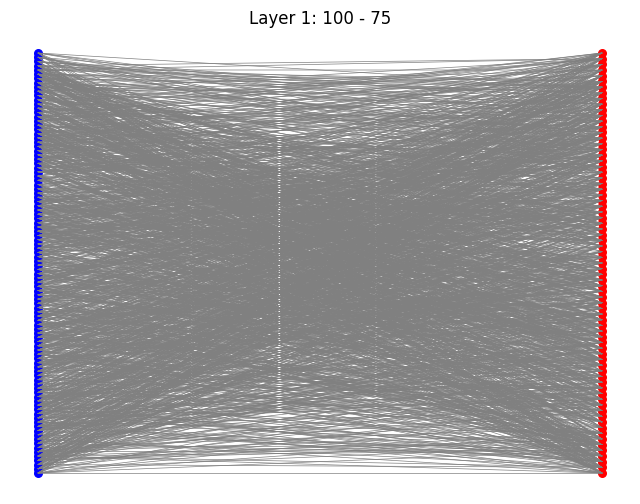

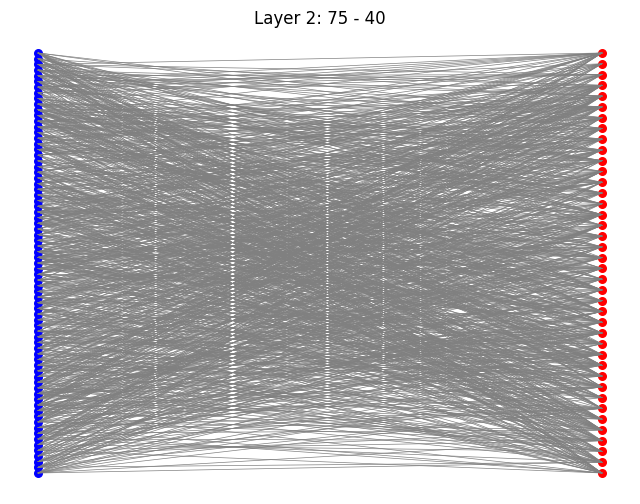

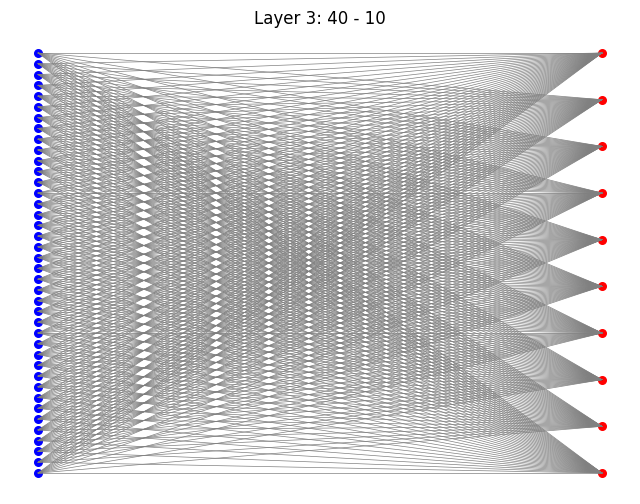

In [85]:
W1_after = model.layers[0].get_weights()[0]
W2_after = model.layers[1].get_weights()[0]
W3_after = model.layers[2].get_weights()[0]

draw_layer_connections(W1_after, 100, 75, "Layer 1: 100 - 75")
draw_layer_connections(W2_after, 75, 40, "Layer 2: 75 - 40")
draw_layer_connections(W3_after, 40, 10, "Layer 3: 40 - 10")


In [86]:
def prune(Weight, Mask):
    W = Weight.numpy()
    flat_W = W.flatten()
    mask_flat = Mask.flatten()
    
    nz_indices = np.where(Mask.flatten())[0]
    nz_values = flat_W[nz_indices]
    
    sorted_idx = np.argsort(np.abs(nz_values))

    k = int(zeta * len(nz_indices))
    k = max(1, min(k, len(nz_indices)))
    
    prune_indices = nz_indices[sorted_idx[:k]]

    rows = prune_indices // W.shape[1]
    cols = prune_indices % W.shape[1]

    W[rows, cols] = 0
    Mask[rows, cols] = False
    
    Weight.assign(W)

    return k

In [87]:
def regrow(Weight, Mask, k):
    W = Weight.numpy()
    mask_flat = Mask.flatten()
    
    # Use mask to find dead edges
    zero_idx = np.where(mask_flat == False)[0]

    k = min(k, len(zero_idx))
    if k == 0:
        return
        
    # Randomly select the index to regrow
    grow_idx = np.random.choice(zero_idx, size=k, replace=False)

    rows = grow_idx // W.shape[1]
    cols = grow_idx % W.shape[1]

    # Random init of new weights
    W[rows, cols] = np.random.normal(0, 0.1, size=k)

    Mask[rows, cols] = True
    Weight.assign(W)

100%|████████████████████████████████████| 469/469 [00:01<00:00, 463.92it/s, dt=0.0010s, loss=0.2736, batch_acc=0.9375]


Epoch 1: accuracy=0.9554
Epoch 1 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 451.60it/s, dt=0.0010s, loss=0.1975, batch_acc=0.9375]


Epoch 2: accuracy=0.9542
Epoch 2 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.13it/s, dt=0.0010s, loss=0.1106, batch_acc=0.9479]


Epoch 3: accuracy=0.9576
Epoch 3 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 462.48it/s, dt=0.0010s, loss=0.1259, batch_acc=0.9583]


Epoch 4: accuracy=0.9592
Epoch 4 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 461.14it/s, dt=0.0010s, loss=0.1049, batch_acc=0.9792]


Epoch 5: accuracy=0.9602
Epoch 5 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 446.20it/s, dt=0.0010s, loss=0.1441, batch_acc=0.9583]


Epoch 6: accuracy=0.9612
Epoch 6 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 462.73it/s, dt=0.0010s, loss=0.0430, batch_acc=0.9896]


Epoch 7: accuracy=0.9619
Epoch 7 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 458.87it/s, dt=0.0010s, loss=0.1461, batch_acc=0.9792]


Epoch 8: accuracy=0.9630
Epoch 8 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 447.05it/s, dt=0.0010s, loss=0.0737, batch_acc=0.9688]


Epoch 9: accuracy=0.9641
Epoch 9 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 441.38it/s, dt=0.0005s, loss=0.0854, batch_acc=0.9583]


Epoch 10: accuracy=0.9625
Epoch 10 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 439.48it/s, dt=0.0020s, loss=0.0586, batch_acc=0.9896]


Epoch 11: accuracy=0.9636
Epoch 11 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 423.07it/s, dt=0.0010s, loss=0.1772, batch_acc=0.9479]


Epoch 12: accuracy=0.9647
Epoch 12 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 447.46it/s, dt=0.0010s, loss=0.0884, batch_acc=0.9479]


Epoch 13: accuracy=0.9663
Epoch 13 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 457.08it/s, dt=0.0010s, loss=0.0462, batch_acc=0.9896]


Epoch 14: accuracy=0.9666
Epoch 14 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 445.77it/s, dt=0.0010s, loss=0.0464, batch_acc=0.9896]


Epoch 15: accuracy=0.9666
Epoch 15 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 456.43it/s, dt=0.0010s, loss=0.0420, batch_acc=0.9792]


Epoch 16: accuracy=0.9679
Epoch 16 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 453.97it/s, dt=0.0010s, loss=0.1132, batch_acc=0.9792]


Epoch 17: accuracy=0.9687
Epoch 17 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 459.78it/s, dt=0.0010s, loss=0.0987, batch_acc=0.9479]


Epoch 18: accuracy=0.9660
Epoch 18 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 456.22it/s, dt=0.0010s, loss=0.0955, batch_acc=0.9688]


Epoch 19: accuracy=0.9684
Epoch 19 done


100%|████████████████████████████████████| 469/469 [00:00<00:00, 469.92it/s, dt=0.0010s, loss=0.2036, batch_acc=0.9583]


Epoch 20: accuracy=0.9687
Epoch 20 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 467.39it/s, dt=0.0010s, loss=0.1687, batch_acc=0.9583]


Epoch 21: accuracy=0.9690
Epoch 21 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 467.86it/s, dt=0.0010s, loss=0.0686, batch_acc=0.9792]


Epoch 22: accuracy=0.9696
Epoch 22 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 450.71it/s, dt=0.0015s, loss=0.1587, batch_acc=0.9375]


Epoch 23: accuracy=0.9697
Epoch 23 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 467.85it/s, dt=0.0010s, loss=0.0591, batch_acc=0.9792]


Epoch 24: accuracy=0.9703
Epoch 24 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 463.46it/s, dt=0.0005s, loss=0.0617, batch_acc=0.9896]


Epoch 25: accuracy=0.9704
Epoch 25 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 459.35it/s, dt=0.0005s, loss=0.0945, batch_acc=0.9792]


Epoch 26: accuracy=0.9693
Epoch 26 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 464.83it/s, dt=0.0010s, loss=0.0819, batch_acc=0.9792]


Epoch 27: accuracy=0.9710
Epoch 27 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 468.09it/s, dt=0.0005s, loss=0.1000, batch_acc=0.9583]


Epoch 28: accuracy=0.9709
Epoch 28 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 462.99it/s, dt=0.0010s, loss=0.1245, batch_acc=0.9583]


Epoch 29: accuracy=0.9711
Epoch 29 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.74it/s, dt=0.0005s, loss=0.0532, batch_acc=0.9896]


Epoch 30: accuracy=0.9717
Epoch 30 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.54it/s, dt=0.0010s, loss=0.0572, batch_acc=0.9688]


Epoch 31: accuracy=0.9717
Epoch 31 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.30it/s, dt=0.0010s, loss=0.0547, batch_acc=0.9896]


Epoch 32: accuracy=0.9722
Epoch 32 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 462.28it/s, dt=0.0015s, loss=0.0433, batch_acc=1.0000]


Epoch 33: accuracy=0.9727
Epoch 33 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.53it/s, dt=0.0010s, loss=0.0300, batch_acc=1.0000]


Epoch 34: accuracy=0.9706
Epoch 34 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.99it/s, dt=0.0010s, loss=0.0995, batch_acc=0.9792]


Epoch 35: accuracy=0.9714
Epoch 35 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 466.22it/s, dt=0.0010s, loss=0.0384, batch_acc=0.9896]


Epoch 36: accuracy=0.9723
Epoch 36 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 454.65it/s, dt=0.0010s, loss=0.0918, batch_acc=0.9583]


Epoch 37: accuracy=0.9723
Epoch 37 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.26it/s, dt=0.0010s, loss=0.1308, batch_acc=0.9583]


Epoch 38: accuracy=0.9732
Epoch 38 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 460.93it/s, dt=0.0010s, loss=0.0333, batch_acc=0.9896]


Epoch 39: accuracy=0.9732
Epoch 39 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 466.61it/s, dt=0.0010s, loss=0.1128, batch_acc=0.9688]


Epoch 40: accuracy=0.9737
Epoch 40 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 453.15it/s, dt=0.0005s, loss=0.1023, batch_acc=0.9792]


Epoch 41: accuracy=0.9737
Epoch 41 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 466.83it/s, dt=0.0005s, loss=0.0353, batch_acc=1.0000]


Epoch 42: accuracy=0.9711
Epoch 42 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 461.83it/s, dt=0.0010s, loss=0.0848, batch_acc=0.9688]


Epoch 43: accuracy=0.9728
Epoch 43 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 457.10it/s, dt=0.0010s, loss=0.0562, batch_acc=0.9896]


Epoch 44: accuracy=0.9740
Epoch 44 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 466.42it/s, dt=0.0010s, loss=0.0553, batch_acc=0.9896]


Epoch 45: accuracy=0.9741
Epoch 45 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 464.34it/s, dt=0.0010s, loss=0.1259, batch_acc=0.9583]


Epoch 46: accuracy=0.9742
Epoch 46 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 465.26it/s, dt=0.0010s, loss=0.1460, batch_acc=0.9583]


Epoch 47: accuracy=0.9742
Epoch 47 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 444.51it/s, dt=0.0010s, loss=0.1351, batch_acc=0.9583]


Epoch 48: accuracy=0.9741
Epoch 48 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 388.55it/s, dt=0.0010s, loss=0.0490, batch_acc=0.9792]


Epoch 49: accuracy=0.9746
Epoch 49 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 454.69it/s, dt=0.0010s, loss=0.0471, batch_acc=0.9896]


Epoch 50: accuracy=0.9722
Epoch 50 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 448.94it/s, dt=0.0010s, loss=0.0497, batch_acc=0.9792]


Epoch 51: accuracy=0.9736
Epoch 51 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 464.33it/s, dt=0.0010s, loss=0.1385, batch_acc=0.9688]


Epoch 52: accuracy=0.9747
Epoch 52 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 457.77it/s, dt=0.0005s, loss=0.0891, batch_acc=0.9688]


Epoch 53: accuracy=0.9751
Epoch 53 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 463.42it/s, dt=0.0010s, loss=0.0677, batch_acc=0.9792]


Epoch 54: accuracy=0.9748
Epoch 54 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 451.35it/s, dt=0.0005s, loss=0.0251, batch_acc=0.9896]


Epoch 55: accuracy=0.9751
Epoch 55 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 459.77it/s, dt=0.0010s, loss=0.0447, batch_acc=0.9792]


Epoch 56: accuracy=0.9754
Epoch 56 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 446.37it/s, dt=0.0010s, loss=0.1858, batch_acc=0.9375]


Epoch 57: accuracy=0.9751
Epoch 57 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 438.84it/s, dt=0.0005s, loss=0.0439, batch_acc=0.9792]


Epoch 58: accuracy=0.9720
Epoch 58 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 451.62it/s, dt=0.0010s, loss=0.0485, batch_acc=0.9896]


Epoch 59: accuracy=0.9740
Epoch 59 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 460.43it/s, dt=0.0010s, loss=0.0510, batch_acc=0.9792]


Epoch 60: accuracy=0.9752
Epoch 60 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 464.57it/s, dt=0.0010s, loss=0.0398, batch_acc=0.9896]


Epoch 61: accuracy=0.9758
Epoch 61 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 451.16it/s, dt=0.0005s, loss=0.1174, batch_acc=0.9583]


Epoch 62: accuracy=0.9755
Epoch 62 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 459.79it/s, dt=0.0010s, loss=0.0234, batch_acc=1.0000]


Epoch 63: accuracy=0.9757
Epoch 63 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 458.89it/s, dt=0.0010s, loss=0.1256, batch_acc=0.9688]


Epoch 64: accuracy=0.9761
Epoch 64 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 457.54it/s, dt=0.0010s, loss=0.0654, batch_acc=0.9896]


Epoch 65: accuracy=0.9761
Epoch 65 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 447.48it/s, dt=0.0010s, loss=0.0208, batch_acc=1.0000]


Epoch 66: accuracy=0.9735
Epoch 66 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 453.52it/s, dt=0.0010s, loss=0.0815, batch_acc=0.9792]


Epoch 67: accuracy=0.9760
Epoch 67 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 463.00it/s, dt=0.0010s, loss=0.0300, batch_acc=1.0000]


Epoch 68: accuracy=0.9756
Epoch 68 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 453.76it/s, dt=0.0015s, loss=0.0225, batch_acc=0.9896]


Epoch 69: accuracy=0.9766
Epoch 69 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.76it/s, dt=0.0005s, loss=0.0565, batch_acc=0.9688]


Epoch 70: accuracy=0.9766
Epoch 70 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 464.12it/s, dt=0.0010s, loss=0.0325, batch_acc=0.9896]


Epoch 71: accuracy=0.9768
Epoch 71 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 456.87it/s, dt=0.0010s, loss=0.1537, batch_acc=0.9271]


Epoch 72: accuracy=0.9772
Epoch 72 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 450.93it/s, dt=0.0010s, loss=0.0720, batch_acc=0.9896]


Epoch 73: accuracy=0.9772
Epoch 73 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 458.44it/s, dt=0.0010s, loss=0.0362, batch_acc=0.9896]


Epoch 74: accuracy=0.9741
Epoch 74 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 461.14it/s, dt=0.0010s, loss=0.0107, batch_acc=1.0000]


Epoch 75: accuracy=0.9761
Epoch 75 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.75it/s, dt=0.0010s, loss=0.0353, batch_acc=0.9896]


Epoch 76: accuracy=0.9768
Epoch 76 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.07it/s, dt=0.0010s, loss=0.0639, batch_acc=0.9896]


Epoch 77: accuracy=0.9768
Epoch 77 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 457.13it/s, dt=0.0010s, loss=0.1088, batch_acc=0.9479]


Epoch 78: accuracy=0.9771
Epoch 78 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 455.73it/s, dt=0.0010s, loss=0.0581, batch_acc=0.9792]


Epoch 79: accuracy=0.9771
Epoch 79 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 442.19it/s, dt=0.0015s, loss=0.1932, batch_acc=0.9583]


Epoch 80: accuracy=0.9775
Epoch 80 done


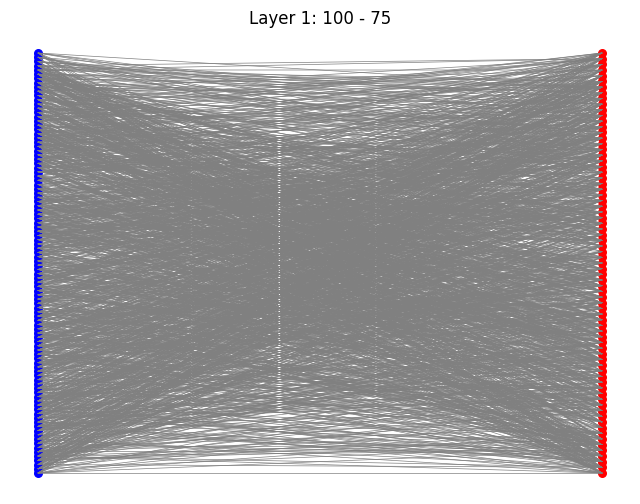

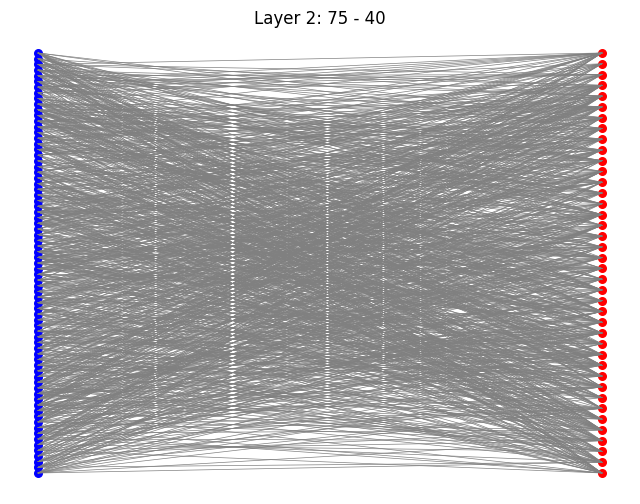

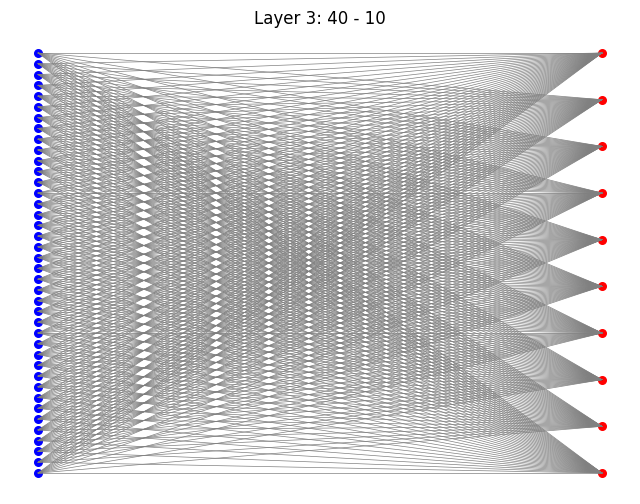

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.9600 - loss: 0.1364
Test accuracy: 0.9599999785423279


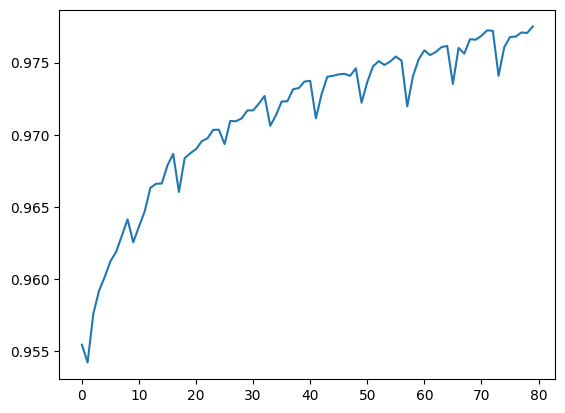

In [88]:
zeta = 0.3
acc_thresh = 0.99
N = 8
acc = []

for epoch in range(80):
    correct_total = 0
    total_samples = 0
    bar = tqdm(dataset)

    for x_batch, y_batch in bar:
        t0 = time.time()
        loss_value, acc_value = train_step(x_batch, y_batch)
        dt = time.time() - t0
        
        batch_size = x_batch.shape[0]
        correct_total += acc_value.numpy() * batch_size
        total_samples += batch_size
        bar.set_postfix({
            "dt": f"{dt:.4f}s",
            "loss": f"{loss_value:.4f}",
            "batch_acc": f"{acc_value:.4f}"
        })

    epoch_acc = correct_total / total_samples
    acc.append(epoch_acc)
    print(f"Epoch {epoch+1}: accuracy={epoch_acc:.4f}")

    if epoch_acc >= acc_thresh:
        print("Reached target accuracy")
        break

    # Every N epochs: prune and regrow
    if epoch % N == 0:
        k = prune(W1, mask1); regrow(W1, mask1, k)
        k = prune(W2, mask2); regrow(W2, mask2, k)
        k = prune(W3, mask3); regrow(W3, mask3, k)

    print(f"Epoch {epoch+1} done")

draw_layer_connections(W1, 100, 75, "Layer 1: 100 - 75")
draw_layer_connections(W2, 75, 40, "Layer 2: 75 - 40")
draw_layer_connections(W3, 40, 10, "Layer 3: 40 - 10")

plt.plot(acc)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

In [93]:
tot_w1 = np.where(mask1.flatten())[0]
tot_w2 = np.where(mask2.flatten())[0]
tot_w3 = np.where(mask3.flatten())[0]

Total_parameters = tot_w1.size + tot_w2.size + tot_w3.size
print("Total sparse parameters:",Total_parameters)

print("Total dense parameters:", model.count_params())


Total sparse parameters: 2778
Total dense parameters: 11025
